## THE AIM IS TO SHOW  THAT, THE OPTIMIZER IS ABLE TO GET THE THETA OF THE DIGITAL TWIN

In [1]:
import numpy as np
from src.digital_twin.bess import BatteryEnergyStorageSystem
from src.online_learning.optimizer import Optimizer
from src.online_learning.utils import utils
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
alpha = 0.5
optimizer_method = 'L-BFGS-B'
#optimizer_method ='BFGS'
#optimizer_method = 'SLSQP' #each param explodes
number_of_restarts = 1
bounds = [(0, 1000), (0, 1000), (0, 1000)] # left r0 was: 0.01, right rc: 100, right c: 100
scale_factor = [1e-4, 1e-4, 1e3] #c before: 10^7

In [3]:
relative_path_ground = os.path.join('..', '..', 'src', 'online_learning', 'initialization', 'ground_20.csv')
path_ground = utils.get_absolute_path(relative_path_ground)

# Load Dataframe
df = pd.read_csv(path_ground)
    
v_real = df['voltage'].values
i_real = df['current'].values
t_real = df['temperature'].values
time = df['time']
    
# Load YAML:
relative_path_grid = os.path.join('..','..','src','online_learning','initialization','grid_parameters')
path_grid = utils.get_absolute_path(relative_path_grid)
grid_parameters = utils.load_from_yaml(path_grid)
    
relative_path_electrical_params = os.path.join('..','..','src','online_learning',
                                                           'initialization','electrical_params')
path_electrical_params = utils.get_absolute_path(relative_path_electrical_params)
electrical_params = utils.load_from_yaml(path_electrical_params)
    
relative_path_thermal_params = os.path.join('..', '..', 'src', 'online_learning',
                                                           'initialization', 'thermal_params')
path_thermal_params = utils.get_absolute_path(relative_path_thermal_params)
    
thermal_params = utils.load_from_yaml(path_thermal_params)
models_config = [electrical_params, thermal_params]
    
relative_path_battery_options = os.path.join('..', '..', 'src', 'online_learning',
                                                        'initialization', 'battery_options')
path_battery_options = utils.get_absolute_path(relative_path_battery_options)
    
battery_options = utils.load_from_yaml(path_battery_options)
    
load_var = 'current'
    
battery = BatteryEnergyStorageSystem(
            models_config=models_config,
            battery_options=battery_options,
            input_var=load_var
            )

#TODO: PASSO I VALORI REALI ALLA BATTERIA DELL'OTTIMIZZ. -> CAMBIA ???
#TODO: MISMATCH BATTERIE ???

reset_info = {'electricala_params': electrical_params, 'thermal_params': thermal_params}
battery.reset(reset_info)
    
battery.init({'dissipated_heat' : 0 }) # check if you can remove it
        
elapsed_time = 0
dt = 1            
v_optimizer = list()
temp_optimizer = list()

#battery_results = battery.get_last_results()
optimizer = Optimizer(models_config=models_config, battery_options=battery_options, load_var=load_var,
                      init_info=reset_info, bounds=bounds, scale_factor=scale_factor)

<Axes: >

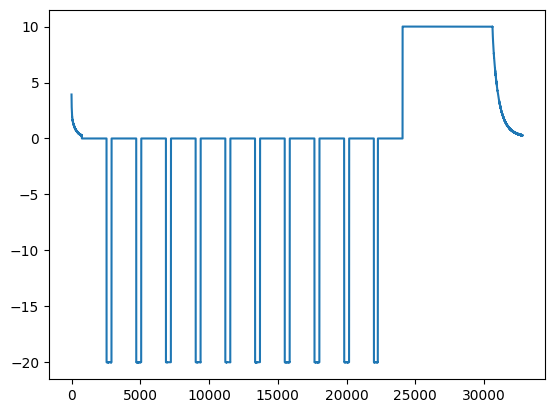

In [20]:
df['current'].plot()

In [4]:
for k, load in enumerate(i_real):
    elapsed_time += dt
    battery.t_series.append(elapsed_time)
    dt = df['time'].iloc[k] - df['time'].iloc[k - 1] if k > 0 else 1.0
    battery.step(load, dt, k)

In [5]:
results = battery.build_results_table()
results = results['operations']
v = results['voltage']
v_real = np.array(v)
v_real = v_real[1:len(v_real)]
t = results['temperature']
t_real = np.array(t)
t_real = t_real[1:len(t_real)]

In [6]:
theta = optimizer.step(i_real=i_real, v_real=v_real,
                       t_real=t_real,optimizer_method= optimizer_method,
                       alpha=alpha,dt=dt, number_of_restarts= number_of_restarts)

restart number : 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.90351D+05    |proj g|=  7.94904D+02
THETA [555.64007158 185.90005879 992.48546223]


At iterate    1    f=  2.42798D+05    |proj g|=  4.65370D+00
the gradient is : [1.9615108612924812, 0.0, 0.0]
THETA
 [555.51967162 186.19498349 992.78467777]
At iterate    2    f=  2.42796D+05    |proj g|=  2.22353D+00
the gradient is : [0.020989682525396347, 0.0, 0.0]
THETA
At iterate    3    f=  2.42778D+05    |proj g|=  1.69850D+01
 [554.67682108 191.65700703 994.30186137]
the gradient is : [0.0, 10.652781929820776, 10.179870878346264]
THETA [553.4980791  203.50377114 995.92715151]


At iterate    4    f=  2.42761D+05    |proj g|=  3.43920D+01
the gradient is : [0.0, 30.613763374276456, 30.220046755857762]
THETA [552.91533354 210.66916498 996.5036768 ]


At iterate    5    f=  2.42758D+05   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [7]:
r0 = battery._electrical_model.r0.resistance
rc = battery._electrical_model.rc.resistance
c = battery._electrical_model.rc.capacity
theta_to_get = {'r0':r0,'rc':rc,'c':c}

In [8]:
print("theta_dt:",theta_to_get)
print("theta_optimizer:",theta)

theta_dt: {'r0': 0.04, 'rc': 0.01, 'c': 10000.0}
theta_optimizer: {'r0': 0.055801865383050986, 'rc': 0.1, 'c': 1000000.0}


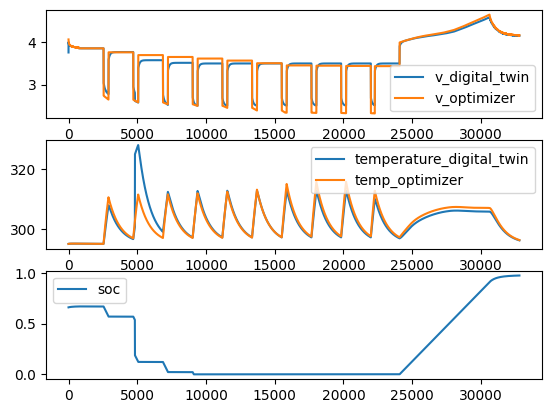

In [9]:
v_optimizer = optimizer.get_v_hat()
temp_optimizer = optimizer.get_t_hat()

# plotting phase:
results = battery.build_results_table()
results = results['operations']

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

# Plot voltage data
ax1.plot(results['voltage'], label='v_digital_twin')
#ax1.plot(df['voltage'][0:len(results['voltage'])], label='ground')
ax1.plot(v_optimizer[0:len(results['voltage'])], label='v_optimizer')
ax1.legend()

# Plot temperature data
ax2.plot(results['temperature'], label='temperature_digital_twin')
#ax2.plot(df['temperature'][0:len(results['temperature'])], label='ground')
ax2.plot(temp_optimizer[0:len(results['temperature'])], label='temp_optimizer')
ax2.legend()

# Plot soc data
ax3.plot(results['soc'], label='soc')
#ax3.plot(df['soc'][0:len(results['temperature'])], label='ground')
ax3.legend()

plt.show()

## error

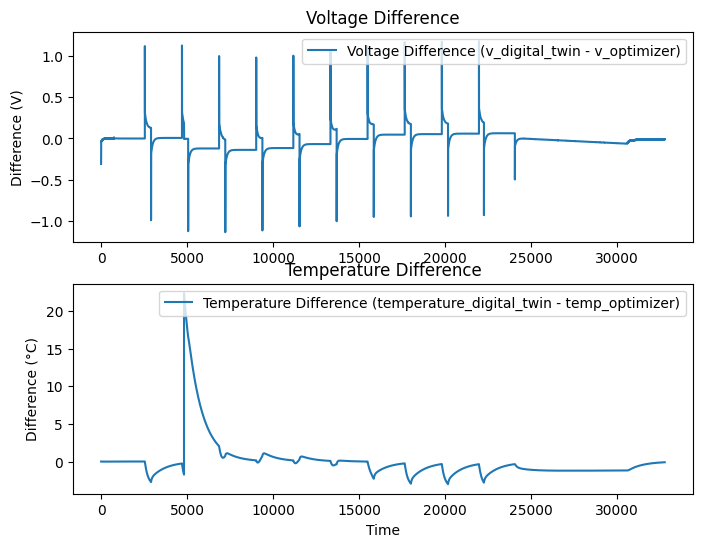

In [22]:
voltage = np.array(results['voltage'])
voltage = voltage[0:len(voltage)-1]
voltage_difference =  voltage - np.array(v_optimizer[0:len(results['voltage'])])

temperature = results['temperature']
temperature = temperature[0:len(temperature)-1]
temperature_difference = temperature - np.array(temp_optimizer[0:len(results['temperature'])])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Plot voltage difference data
ax1.plot(voltage_difference, label='Voltage Difference (v_digital_twin - v_optimizer)')
ax1.set_title('Voltage Difference')
ax1.set_ylabel('Difference (V)')
ax1.legend()

# Plot temperature difference data
ax2.plot(temperature_difference, label='Temperature Difference (temperature_digital_twin - temp_optimizer)')
ax2.set_title('Temperature Difference')
ax2.set_ylabel('Difference (°C)')
ax2.legend()

plt.xlabel('Time')
plt.show()

## If I give the obtained theta to the dt